# Functions to calculate intermediate definitions

In [1]:
# Normal Buying and rebuying is implemented after selling.
import pandas as pd

# Load data
def load_data(filepath):
    """Load stock volume data from an Excel file."""
    volume_df = pd.read_excel(filepath, index_col=0, parse_dates=True)
    return volume_df

# Define function for checking missing data
# def check_missing_data_last_7_days(volume_df, current_date, max_missing_days=2):
#     last_7_days_df = volume_df.loc[current_date - pd.Timedelta(days=6):current_date]
#     for stock in last_7_days_df.columns:
#         na_counts = last_7_days_df[stock].isna().astype(int).groupby(last_7_days_df[stock].notna().astype(int).cumsum()).sum()
#         if any(na_counts > max_missing_days):
#             raise ValueError(f"Not sufficient data available in the last 7 days for stock: {stock}")
#         last_7_days_df[stock] = last_7_days_df[stock].interpolate(method='time')
#     volume_df.update(last_7_days_df)
#     return volume_df

def check_missing_data_last_7_days(volume_df, current_date, max_missing_days=2):
    print("Checking missing volume data...")
    # last_7_days_df = volume_df.loc[current_date - pd.Timedelta(days=6):current_date]
    last_7_datapoints_df = volume_df.tail(7)

    # Check if last_7_days_df is a Series and convert to DataFrame if necessary
    if isinstance(last_7_datapoints_df, pd.Series):
        last_7_datapoints_df = last_7_datapoints_df.to_frame()

    print(f'last 7 datapoints: \n{last_7_datapoints_df.head(7)}')

    for stock in last_7_datapoints_df.columns:
        print(f"Checking na_counts in loop for stock: {stock}")
        na_counts = last_7_datapoints_df[stock].isna().astype(int).groupby(last_7_datapoints_df[stock].notna().astype(int).cumsum()).sum()
        print(f"na_counts: \n{na_counts}")
        if any(na_counts > max_missing_days):
            print(f"Warning: Stock {stock} has more than {max_missing_days} consecutive missing values in the last 7 days.")
            # Drop the stock from the DataFrame
            # volume_df = volume_df.drop(columns=[stock])

        last_7_datapoints_df[stock] = last_7_datapoints_df[stock].interpolate(method='linear')
        print('interpolation completed...')
    return last_7_datapoints_df

def calculate_7_day_moving_avg(volume_df, current_date):
    moving_avg = volume_df.mean().iloc[0]
    return moving_avg

def maximum_buyable_value(volume_df, current_date):
    print(f"Inside maximum_buyable_value: {volume_df.head()}")
    vol_df_cleaned = check_missing_data_last_7_days(volume_df, current_date)
    moving_avg = calculate_7_day_moving_avg(vol_df_cleaned, current_date)
    max_buyable_qty = moving_avg * 0.10
    return max_buyable_qty

# Function to load data from an Excel file
def load_price_data(filepath):
    """Load stock price data from an Excel file."""
    df = pd.read_excel(filepath, index_col=0, parse_dates=True)
    return df

# Define functions for cleaning data and calculating momentum
def clean_data(df, threshold=0.8):
    if isinstance(df, pd.Series):
        df = df.to_frame()
    min_required = threshold * len(df)
    df_cleaned = df.dropna(axis=1, thresh=min_required)
    df_cleaned = df_cleaned.interpolate(method='time')
    return df_cleaned

def calculate_momentum(df, period):
    df = df.tail(period)
    df = clean_data(df)
    return df.pct_change().mean()

# Define buy_stocks function
def buy_stocks(df, num_stocks, period, momentum_threshold=None):
    momentums = calculate_momentum(df, period)
    if momentum_threshold is not None:
        return momentums[momentums > momentum_threshold].sort_values(ascending=False)
    else:
        return momentums.sort_values(ascending=False).head(num_stocks)



# Back Testing Function

In [7]:
# prompt: if stock is a rebuy stock, then transaction_type should be 'Rebuy' else 'Buy'. Even for Portfolio.append as well it should be 'Rebuy' if stock is a recently sold stock, else it should be 'Normal Buy'

############ Latest Edit ##################
def backtest(df, volume_df, start_date, end_date, initial_cash, buy_period, sell_threshold, rebuy_momentum_threshold, recent_days, num_stocks, sell_charges, buy_charges):
    # Find the nearest available dates in the dataframes
    available_dates = df.index
    available_start_date = available_dates[available_dates >= start_date].min() if available_dates[available_dates >= start_date].size > 0 else start_date
    available_end_date = available_dates[available_dates <= end_date].max() if available_dates[available_dates <= end_date].size > 0 else end_date

    # Ensure start_date is not after end_date
    if available_start_date > available_end_date:
      print("Error: start_date is after end_date.")
      return None, None

    print(f"Adjusted start date: {available_start_date}")
    print(f"Adjusted end date: {available_end_date}")

    portfolio = []
    cash = initial_cash
    history = []
    # dates = pd.date_range(start=start_date, end=end_date)
    dates = available_dates[(available_dates >= available_start_date) & (available_dates <= available_end_date)]

    for current_date in dates:
        print(f"\nCurrent Date: {current_date}")

        # Slice the dataframes for the current date
        df_slice = df[df.index <= current_date]
        volume_slice = volume_df[volume_df.index <= current_date]

        # Selling Stocks
        if portfolio:  # Check if portfolio is not empty
          print("Checking if any stocks meet sell threshold...")
          for stock, buy_date, buy_price, shares, cash_spent, desc in portfolio[:]:
              stock_momentum = calculate_momentum(df_slice[stock], period=7)  # Weekly momentum
              if stock_momentum.item() < sell_threshold:
                  sell_price = df_slice[stock].iloc[-1]
                  cash += shares * sell_price * (100-sell_charges)/100
                  portfolio.remove((stock, buy_date, buy_price, shares, cash_spent, desc))

                  # Record the transaction in history
                  history.append({
                      'stock': stock,
                      'buy_date': buy_date,
                      'buy_price': buy_price,
                      'sell_price': sell_price,
                      'shares': shares,
                      'cash_spent': cash_spent,
                      'cash_received': shares * sell_price,
                      'sell_date': current_date,
                      'transaction_type': 'Sell'
                  })
                  print(f"Sold {stock} at {sell_price} due to low momentum. Added to history.")


        # Normal Buying (after Selling or regardless of Selling)
        if cash > 0:  # Check if there is cash available for new buys
            to_buy = buy_stocks(df_slice, num_stocks, buy_period)
            print(f"Stocks to buy on {current_date}: \n{to_buy}")
            # Check for recently sold stocks and apply momentum filter
            recently_sold_stocks = [entry['stock'] for entry in history if pd.to_datetime(entry['sell_date']) >= current_date - pd.Timedelta(days=recent_days) and entry['transaction_type'] == 'Sell']
            stocks_to_remove = []
            rebuy_stocks = []
            for stock in to_buy.index:
                if stock in recently_sold_stocks:
                  rebuy_momentum = calculate_momentum(df_slice[stock], period=7)
                  if rebuy_momentum.item() > rebuy_momentum_threshold:
                      rebuy_stocks.append(stock)
                  else:
                      stocks_to_remove.append(stock)
            to_buy = to_buy.drop(stocks_to_remove)
            print(f"Stocks to rebuy on {current_date}: {rebuy_stocks}")
            cash_avail_per_stock = (cash * ((100 - buy_charges)/100)) / len(to_buy) if len(to_buy) > 0 else 0
            print(f"Cash available per stock: {cash_avail_per_stock}")

            for stock in to_buy.index:
                print(f"Checking stock: {stock}")
                buy_price = df_slice[stock].iloc[-1]
                print(f"Buy price for {stock} on {current_date}: {buy_price}")
                max_value = maximum_buyable_value(volume_slice[stock], current_date)
                print(f"Maximum buyable value for {stock} on {current_date}: {max_value}")
                available_qty = cash_avail_per_stock / buy_price
                print(f"Available quantity for {stock} on {current_date}: {available_qty}")

                if stock in rebuy_stocks:
                    transaction_type = 'Rebuy'
                else:
                  transaction_type = 'Buy'

                print(f"Transaction type: {transaction_type}")
                if cash_avail_per_stock > max_value:
                    print(f"Cash exceeds the maximum buyable value for {stock}. Buying based on max value.")
                    shares_to_buy = np.floor(max_value / buy_price)
                    cash_spent = shares_to_buy * buy_price
                else:
                    print(f"Buying {stock} based on available cash.")
                    shares_to_buy = np.floor(available_qty)
                    cash_spent = shares_to_buy * buy_price

                if shares_to_buy > 0:
                    portfolio.append((stock, current_date, buy_price, shares_to_buy, cash_spent, transaction_type))
                    cash -= cash_spent
                    # Record the transaction in history
                    history.append({
                        'stock': stock,
                        'buy_date': current_date,
                        'buy_price': buy_price,
                        'sell_price': "",
                        'shares': shares_to_buy,
                        'cash_spent': cash_spent,
                        'cash_received': "",
                        'sell_date': "",
                        'transaction_type': transaction_type # Use the determined transaction type
                    })
                    print(f"{transaction_type} {stock} at {buy_price}. Added to history.")
                else:
                    print(f"Cannot buy {stock}: insufficient cash or shares to buy is zero.")
    # portfolio_df = pd.DataFrame(portfolio, columns=['Stock', 'Buy Date', 'Buy Price', 'Shares', 'Cash Spent', 'Transaction Type'])
    return portfolio, history, cash

# Profit Calculation

In [ ]:
# # prompt: for any given date, calculate realized profit (sold stocks) from transaction history & unrealized profit (stocks still held) from the portfolio

# def calculate_realized_and_unrealized_profit(history, portfolio, df, target_date):
#     realized_profit = 0
#     unrealized_profit = 0

#     # Calculate realized profit from the transaction history
#     for transaction in history:
#         if transaction['transaction_type'] == 'Sell' and pd.to_datetime(transaction['sell_date']) <= target_date:
#             realized_profit += transaction['cash_received'] - transaction['cash_spent']

#     # Calculate unrealized profit from the current portfolio
#     for stock, buy_date, buy_price, shares, _, _ in portfolio:
#         if pd.to_datetime(buy_date) <= target_date:  #Consider only stocks bought before or on the target date
#             current_price = df[stock].loc[target_date] if target_date in df.index else df[stock].iloc[-1] #get price at the target date or the last available price.
#             unrealized_profit += (current_price - buy_price) * shares

#     return realized_profit, unrealized_profit

In [3]:
# prompt: rectify above unrealized profit calculation where current price is calculated for target date. if the date is not available then most nearest date available which is less than the target date should be picked

def calculate_realized_and_unrealized_profit(history, portfolio, df, target_date):
    realized_profit = 0
    unrealized_profit = 0

    # Calculate realized profit from the transaction history
    for transaction in history:
        if transaction['transaction_type'] == 'Sell' and pd.to_datetime(transaction['sell_date']) <= target_date:
            realized_profit += transaction['cash_received'] - transaction['cash_spent']

    # Calculate unrealized profit from the current portfolio
    for stock, buy_date, buy_price, shares, _, _ in portfolio:
        if pd.to_datetime(buy_date) <= target_date:  # Consider only stocks bought before or on the target date
            # Find the nearest available date less than or equal to the target date
            available_dates = df.index[df.index <= target_date]
            if not available_dates.empty:
                nearest_date = available_dates.max()
                current_price = df[stock].loc[nearest_date]
            else:
                # Handle the case where no dates are available before or on target_date
                print(f"Warning: No price data available before or on {target_date} for {stock}. Using the latest available price.")

            unrealized_profit += (current_price - buy_price) * shares

    return realized_profit, unrealized_profit

# Loading Input Files

In [4]:
# prompt: Load price file & volume file

import pandas as pd
import numpy as np

# ... (rest of your code from the previous response)

# Load price data
price_filepath = "/content/drive/MyDrive/Colab Notebooks/Colab Datasets/Price_2014.xlsx"
price_df = pd.read_excel(price_filepath, index_col=0, parse_dates=True)

# Load volume data
volume_filepath = "/content/drive/MyDrive/Colab Notebooks/Colab Datasets/Stock_Volume.xlsx"
volume_df = pd.read_excel(volume_filepath, index_col=0, parse_dates=True)

# Input paramters

In [27]:

# **Changes start here**: Converting input strings to appropriate types
start_date_input = input("Enter the start date (DD-MM-YYYY): ")
end_date_input = input("Enter the end date (DD-MM-YYYY): ")
try:
    start_date = pd.to_datetime(start_date_input, format='%d-%m-%Y')
    end_date = pd.to_datetime(end_date_input, format='%d-%m-%Y')
    if start_date >= end_date:
        raise ValueError("Start date must be earlier than the end date.")
except ValueError as e:
    print(e)

# **Convert input values to numeric types**
initial_cash = float(input("Input the Cash In Hand (INR): "))
buy_period = int(input("Input the Buy Period (in Days): "))
sell_threshold = float(input("Input the sell_threshold: "))
rebuy_momentum_threshold = float(input("Input the rebuy momentum threshold (e.g., 0.01): "))
recent_days = int(input("Input the definition of recent in days (e.g., 7): "))
num_stocks = int(input("No of Stocks interested: "))
sell_charges = float(input("Input the sell transaction charges in %: "))
buy_charges = float(input("Input the buy transaction charges in %: "))

# **Changes end here**

KeyboardInterrupt: Interrupted by user

In [20]:

# **Changes start here**: Converting input strings to appropriate types
start_date_input = '01-07-2023'
end_date_input = '31-07-2023'
try:
    start_date = pd.to_datetime(start_date_input, format='%d-%m-%Y')
    end_date = pd.to_datetime(end_date_input, format='%d-%m-%Y')
    if start_date >= end_date:
        raise ValueError("Start date must be earlier than the end date.")
except ValueError as e:
    print(e)

# **Convert input values to numeric types**
initial_cash = 100000
buy_period = 365
sell_threshold = -0.01
rebuy_momentum_threshold = 0.01
recent_days = 7
num_stocks = 15
sell_charges = 0.0075
buy_charges = 0.0075
# **Changes end here**

# Test Execution

In [21]:
# prompt: Execute back test & calculate profit for given start date & end date

# Execute backtest
portfolio, history, cash = backtest(price_df, volume_df, start_date, end_date, initial_cash, buy_period, sell_threshold, rebuy_momentum_threshold, recent_days, num_stocks, sell_charges, buy_charges)

Streaming output truncated to the last 5000 lines.
Buy price for Mazagon Dock Shipbuilders Ltd. on 2023-07-19 00:00:00: 1733.0
Inside maximum_buyable_value: Date
2014-01-01   NaN
2014-01-02   NaN
2014-01-03   NaN
2014-01-06   NaN
2014-01-07   NaN
Name: Mazagon Dock Shipbuilders Ltd., dtype: float64
Checking missing volume data...
last 7 datapoints: 
            Mazagon Dock Shipbuilders Ltd.
Date                                      
2023-07-11                    9.339789e+09
2023-07-12                    2.292815e+10
2023-07-13                    1.282186e+10
2023-07-14                    5.933269e+09
2023-07-17                    8.897908e+09
2023-07-18                    4.106372e+09
2023-07-19                    1.509248e+09
Checking na_counts in loop for stock: Mazagon Dock Shipbuilders Ltd.
na_counts: 
Mazagon Dock Shipbuilders Ltd.
1    0
2    0
3    0
4    0
5    0
6    0
7    0
Name: Mazagon Dock Shipbuilders Ltd., dtype: int64
interpolation completed...
Maximum buyable value 

In [22]:
cash

6427.032280000012

In [23]:

#Calculate and print profit

realized_profit, unrealized_profit = calculate_realized_and_unrealized_profit(history, portfolio, price_df, end_date)
print(f"\nRealized Profit: {realized_profit}")
print(f"Unrealized Profit: {unrealized_profit}")
print(f"Total Profit: {realized_profit + unrealized_profit}")


Realized Profit: -407.2500000000001
Unrealized Profit: 11989.05
Total Profit: 11581.8


In [ ]:
# prompt: Export history & portfolio to excel

# Export history to Excel
history_df = pd.DataFrame(history)
history_df.to_excel('transaction_history.xlsx', index=False)

# Export portfolio to Excel
portfolio_df = pd.DataFrame(portfolio)
portfolio_df.to_excel('current_portfolio.xlsx', index=False)

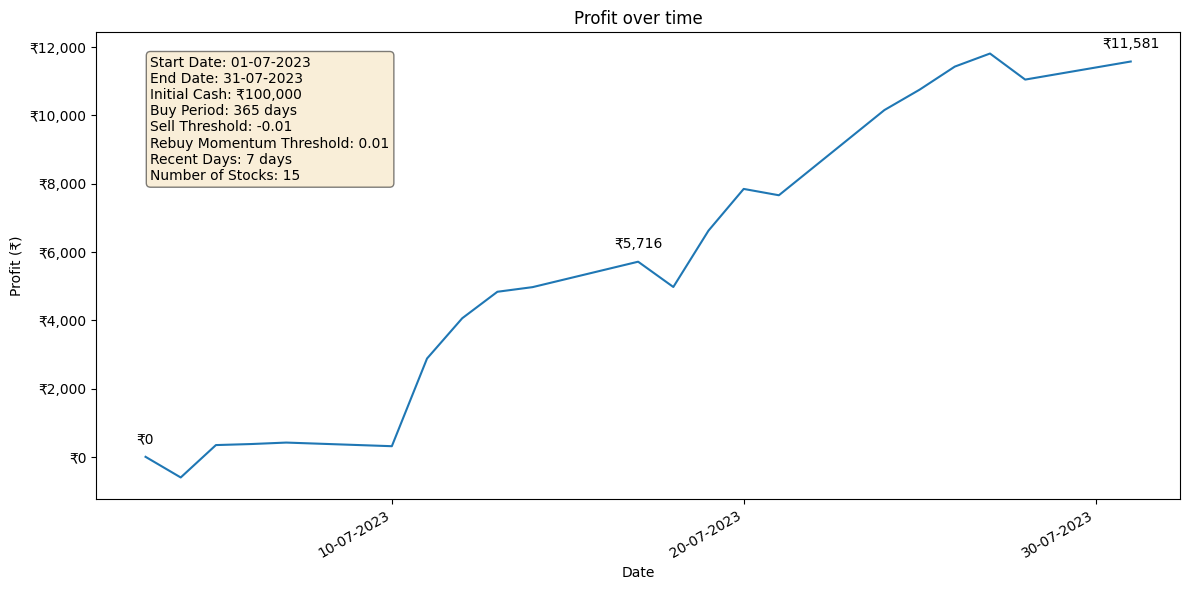

In [24]:
# prompt: for given input of start date & end date check the available dates between them & calculate profit for each available date using calculate_realized_and_unrealized_profit function & plot them in a graph. In graph show data labels at every 7 days including first & last dates. Show labels as integers with comma separators & show rupee symbol. Also, show all input parameters in a text over the chart.

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# ... (Your existing code)

# Plotting
available_dates = price_df.index
available_start_date = available_dates[available_dates >= start_date].min()
available_end_date = available_dates[available_dates <= end_date].max()
dates = available_dates[(available_dates >= available_start_date) & (available_dates <= available_end_date)]
profits = []

for current_date in dates:
    realized_profit, unrealized_profit = calculate_realized_and_unrealized_profit(history, portfolio, price_df, current_date)
    profits.append(realized_profit + unrealized_profit)

plt.figure(figsize=(12, 6))
plt.plot(dates, profits)


# Formatting the x-axis to show dates every 7 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate() # Rotate date labels for better readability


#Adding data labels every 7 days including start and end dates

for i, txt in enumerate(profits):
    if i % 10 == 0 or i == len(profits)-1:
        plt.annotate(f"₹{int(txt):,}", (dates[i], profits[i]), textcoords="offset points", xytext=(0,10), ha='center')


# Formatting the y-axis with comma separators and rupee symbol
formatter = ticker.FuncFormatter(lambda x, pos: f"₹{int(x):,}")
plt.gca().yaxis.set_major_formatter(formatter)


# Adding input parameters as text above the chart
text_str = f"Start Date: {start_date_input}\nEnd Date: {end_date_input}\nInitial Cash: ₹{initial_cash:,}\nBuy Period: {buy_period} days\nSell Threshold: {sell_threshold}\nRebuy Momentum Threshold: {rebuy_momentum_threshold}\nRecent Days: {recent_days} days\nNumber of Stocks: {num_stocks}"
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.xlabel("Date")
plt.ylabel("Profit (₹)")
plt.title("Profit over time")
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

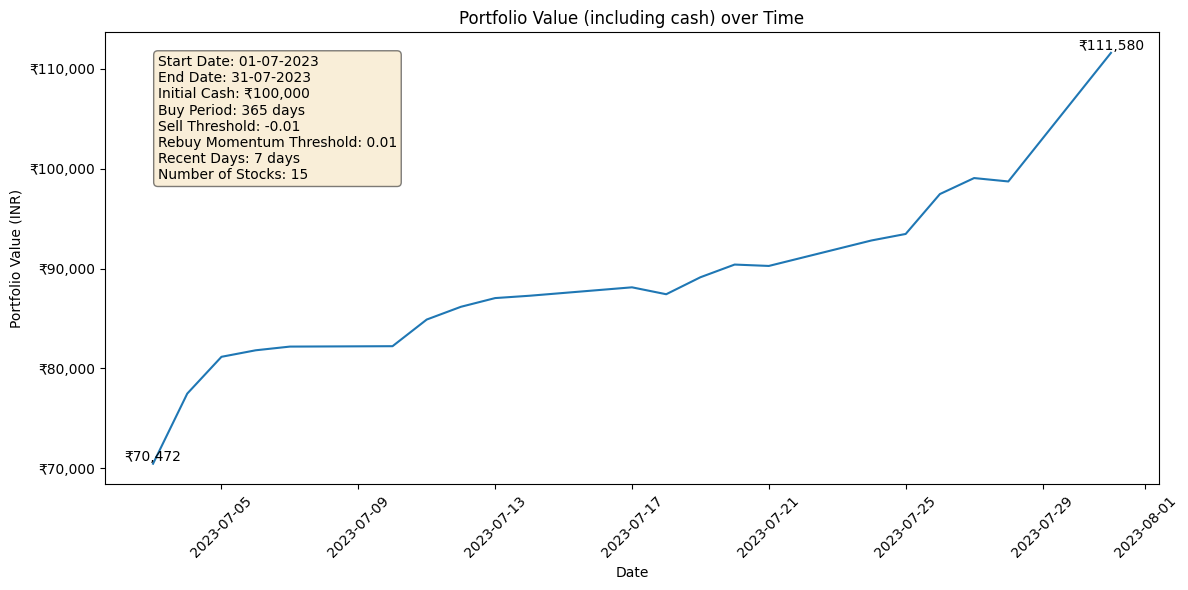

In [25]:
# prompt: Plot portfolio value not profits but current value of the portfolio holding. Show data labels with rupee symbol & as integer with comma separations

import matplotlib.ticker as ticker

# ... (your existing code)

# Plotting portfolio value over time
dates = price_df.index[(price_df.index >= start_date) & (price_df.index <= end_date)]
portfolio_values = []

for current_date in dates:
    current_value = cash  # Start with the remaining cash
    for stock, buy_date, buy_price, shares, _, _ in portfolio:
        if pd.to_datetime(buy_date) <= current_date:
            current_price = price_df[stock].loc[current_date] if current_date in price_df.index else price_df[stock].iloc[-1]
            current_value += current_price * shares
    portfolio_values.append(current_value)


plt.figure(figsize=(12, 6))
plt.plot(dates, portfolio_values)
plt.xlabel("Date")
plt.ylabel("Portfolio Value (INR)")
plt.title("Portfolio Value (including cash) over Time")
plt.grid(False)

# Format y-axis labels with comma separators and rupee symbol
formatter = ticker.FuncFormatter(lambda x, pos: f"₹{x:,.0f}")
plt.gca().yaxis.set_major_formatter(formatter)

# Adding input parameters as text above the chart
text_str = f"Start Date: {start_date_input}\nEnd Date: {end_date_input}\nInitial Cash: ₹{initial_cash:,}\nBuy Period: {buy_period} days\nSell Threshold: {sell_threshold}\nRebuy Momentum Threshold: {rebuy_momentum_threshold}\nRecent Days: {recent_days} days\nNumber of Stocks: {num_stocks}"
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Add data labels every 7 days
for i, date in enumerate(dates):
    if i == 0 or i == len(dates) - 1 or i % 30 == 0:
        plt.text(date, portfolio_values[i], f"₹{portfolio_values[i]:,.0f}", ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

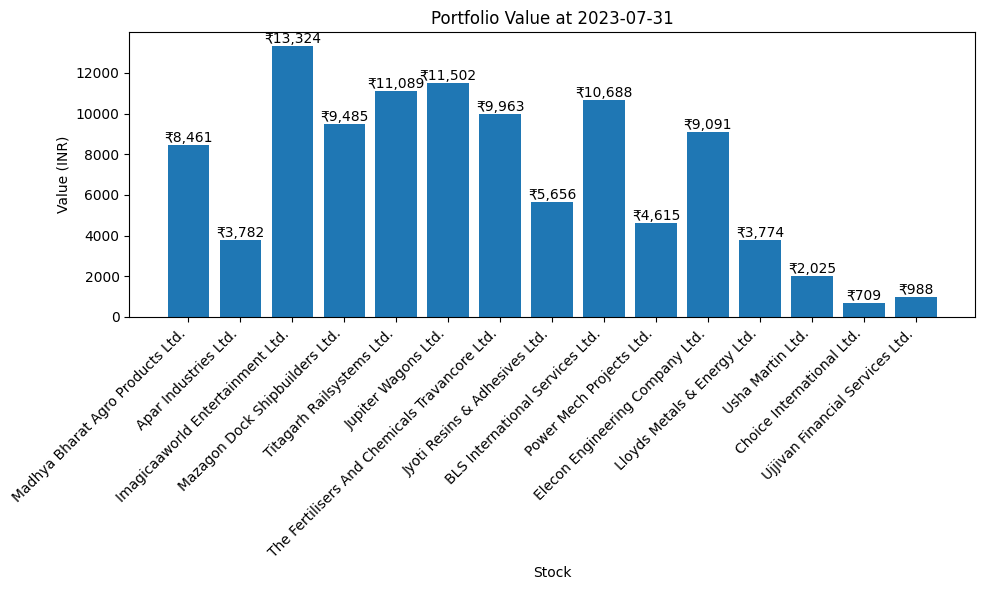

Total portfolio value as on 2023-07-31 00:00:00: ₹105,153
Final cash as on 2023-07-31 00:00:00: ₹6,427


In [26]:
# prompt: In the above portfolio bar chart, first we need to perform group by on portfolio at stock level where we sum up the quantities, then we check current price of the stock, get current value = current price * shares and finally show chart at stock level

# Assuming 'portfolio' and 'price_df' are defined from the previous code

# Group portfolio by stock and sum shares
portfolio_grouped = {}
for stock, buy_date, buy_price, shares, _, _ in portfolio:
    if stock not in portfolio_grouped:
        portfolio_grouped[stock] = 0
    portfolio_grouped[stock] += shares

# Calculate portfolio value at the end date for each stock
stock_values = {}
for stock, shares in portfolio_grouped.items():
    available_dates = price_df.index[price_df.index <= end_date]
    if not available_dates.empty:
        nearest_date = available_dates.max()
        current_price = price_df[stock].loc[nearest_date]
    else:
        # Handle the case where no dates are available before or on target_date
        print(f"Warning: No price data available before or on {end_date} for {stock}. Using the latest available price.")
        current_price = price_df[stock].iloc[-1] # Use the last available price as fallback

    stock_values[stock] = current_price * shares

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(stock_values.keys(), stock_values.values())
plt.xlabel("Stock")
plt.ylabel("Value (INR)")
plt.title(f"Portfolio Value at {end_date.strftime('%Y-%m-%d')}")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Add value labels to each bar
for stock, value in stock_values.items():
    plt.text(stock, value, f"₹{value:,.0f}", ha='center', va='bottom')

plt.show()

# Calculate total portfolio value
total_portfolio_value = sum(stock_values.values())
print(f"Total portfolio value as on {end_date}: ₹{total_portfolio_value:,.0f}")
print(f"Final cash as on {end_date}: ₹{cash:,.0f}")